### В задании сказано сделать классификацию оценки от 1 до 5 звезд продукта по отзыву.

- Можно ли было решать ее как задачц регресии и насколько это правильно?
- По обучению:  Лосс хорошо падал, и качаество на трейне росло - значит модель хорошо обучалась. Однако вот качество на тесте оставалось примерно таким же. 

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re
import nltk
from nltk.tokenize import word_tokenize
import torch
import torch.nn.functional as F

In [2]:
max_words = 4000
max_len = 20
num_classes = 5

# Training
epochs = 20
batch_size = 512
print_batch_n = 100

In [3]:
df = pd.read_excel('review.xls')  

In [4]:
df_X = df['Content']
df_y = df['Rating']

In [5]:
df_y = df_y - 1 # Делаем, что бы был 0 класс, особенность лосса, если подавать 1-5 классы, выдает ошибку, если подавать 0-4 то норм.

In [6]:
df_X[1]

'В целом удобноное приложение...из минусов хотят слишком большой доступ к персональным данным в телефоне,приходится пользоваться в ограниченном режиме'

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.33, random_state=42)

In [8]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

In [9]:
X_train = X_train.apply(preprocess_text)
X_test = X_test.apply(preprocess_text)

In [10]:
X_train[1]

'целое удобноной приложениеиз минус хотеть большой доступ персональный данные телефонеприходиться пользоваться ограниченный режим'

In [11]:
train_corpus = " ".join(X_train)
train_corpus = train_corpus.lower()

In [12]:
nltk.download("punkt")
tokens = word_tokenize(train_corpus)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Intelit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:
tokens[:10]

['наконецтый',
 'исправить',
 'чушь',
 'снеоргинальный',
 'прошивка',
 'приложение',
 'удобно',
 'пользоваться',
 'удобно',
 'использование']

In [14]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [15]:
len(tokens_filtered), len(tokens)

(68998, 69465)

In [16]:
from nltk.probability import FreqDist
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

In [17]:
tokens_filtered_top[:10]

['приложение',
 'удобно',
 'работать',
 'удобный',
 'отлично',
 'нравиться',
 'хороший',
 'отличный',
 'телефон',
 'супер']

In [18]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [19]:
import numpy as np
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [20]:
X_train = np.asarray([text_to_sequence(text, max_len) for text in X_train], dtype=np.int32)
X_test = np.asarray([text_to_sequence(text, max_len) for text in X_test], dtype=np.int32)

In [21]:
import random
import torch
import torch.nn as nn

seed = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [22]:
class Net(nn.Module):
    def __init__(self, vocab_size=20, embedding_dim = 256, out_channel = 128, num_classes = 5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(out_channel, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x)
        #                       B  F  L         
        output = output.permute(0, 2, 1)
        output = self.conv(output)
        output = self.relu(output)
        output = torch.max(output, axis=2).values
        output = self.linear(output)
        
        
        return output

In [23]:
from torch.utils.data import DataLoader, Dataset

class DataWrapper(Dataset):
    def __init__(self, data, target=None, transform=None):
        self.data = torch.from_numpy(data).long()
        if target is not None:
            self.target = torch.from_numpy(np.array(target)).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index] if self.target is not None else None
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [24]:
train_dataset = DataWrapper(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(X_test, y_test)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [25]:
model = Net(vocab_size=max_words)

print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))


#model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=10e-3)
criterion = nn.CrossEntropyLoss()
loss_history = []
acc_history = []
val_acc_history = []
for epoch in range(1, epochs + 1):
    print(f"Train epoch {epoch}/{epochs}")
    for i, (data, target) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        
        # data = data.cuda()
        # target = target.cuda()
        
        # compute output
        output = model(data)
        
        # compute gradient and do SGD step
        loss = criterion(output, target)
        loss.backward()
        
        optimizer.step()
        pos = ((np.argmax(output.detach().numpy(), axis=1)) ==  (target.detach().numpy())).sum()      
        acc = pos / len(target)
        
        model.eval()
        sumpos = 0
        sumlen = 0
        for val_data, val_target in val_loader:
            val_output = model(val_data)
            val_pos = ((np.argmax(val_output.detach().numpy(), axis=1)) ==  (val_target.detach().numpy())).sum()
            sumpos += val_pos
            sumlen += len(val_target)
        val_acc = sumpos / sumlen
        if i%print_batch_n == 0:
            loss = loss.float().item()
            print("Step {}: loss={} acc={} val_acc={}".format(i, loss, acc, val_acc))
            loss_history.append(loss)
            acc_history.append(acc)
            val_acc_history.append(val_acc)

Net(
  (embedding): Embedding(4000, 256)
  (conv): Conv1d(256, 128, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (linear): Linear(in_features=128, out_features=5, bias=True)
)
Parameters: 1123077
Train epoch 1/20
Step 0: loss=1.8387144804000854 acc=0.0859375 val_acc=0.7125256673511293
Train epoch 2/20
Step 0: loss=0.5834066867828369 acc=0.814453125 val_acc=0.7522733939571722
Train epoch 3/20
Step 0: loss=0.4126602113246918 acc=0.880859375 val_acc=0.7550601349369317
Train epoch 4/20
Step 0: loss=0.316721111536026 acc=0.89453125 val_acc=0.7456732179524788
Train epoch 5/20
Step 0: loss=0.3045041561126709 acc=0.916015625 val_acc=0.7509533587562335
Train epoch 6/20
Step 0: loss=0.21730968356132507 acc=0.94140625 val_acc=0.7354062775007334
Train epoch 7/20
Step 0: loss=0.2843067944049835 acc=0.908203125 val_acc=0.627750073335289
Train epoch 8/20
Step 0: loss=0.2015341967344284 acc=0.9375 val_acc=0.7424464652390731
Train epoch 9/20
Step 0: loss=0.18749690055847168 acc=0.94140625 val_acc=

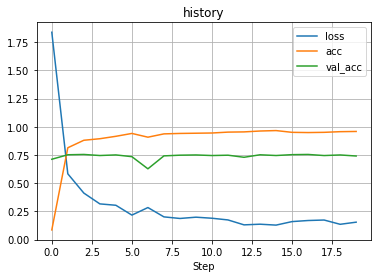

In [26]:
import matplotlib.pyplot as plt

plt.title('history')
plt.grid(True)
plt.xlabel('Step')
plt.plot(loss_history, label='loss')
plt.plot(acc_history, label='acc')
plt.plot(val_acc_history, label='val_acc')
plt.legend();